In [1]:
# Core scientific stack
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from glob import glob
import os

# NetCDF
from netCDF4 import Dataset, num2date, date2num

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, colors, cbook
import seaborn as sns
import cmocean as cmocn  # comment out if unused

# Machine Learning
from sklearn.cluster import DBSCAN, OPTICS, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             silhouette_score,
                             pairwise_distances)
from imblearn.over_sampling import SMOTE
import joblib

# Scipy
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist, cosine
from scipy.ndimage import convolve1d

# Parallelism
from joblib import Parallel, delayed

# Tensorflow
import tensorflow as tf

# Jupyter Magic
%matplotlib inline

2025-09-18 21:44:00.357157: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 21:44:00.383968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-18 21:44:00.383993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-18 21:44:00.385075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-18 21:44:00.389759: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# fname = '../testMatchups/rainFlagRemovedBuoyDataBadQualityRemovedMatchupAmbuguitiesAdded_waveAndGlorysAdded_manualRemovedSomeData_withRain.nc'
# ds = xr.open_dataset(fname)

ds = xr.open_dataset('../testMatchups/rainFlagRemovedBuoyDataBadQualityRemovedMatchupAmbuguitiesAdded_waveAndGlorysAdded_manualRemovedSomeData.nc')
data = ds.to_dataframe()

In [3]:
ds

<xarray.Dataset>
Dimensions:                                   (count: 264416)
Coordinates:
  * count                                     (count) int64 0 1 ... 295512
Data variables: (12/121)
    WDIR (TAO)                                (count) float32 140.6 ... 143.2
    WDIR_QC                                   (count) float32 2.0 2.0 ... 2.0
    WDIR_DM                                   (count) |S1 b'D' b'D' ... b'D'
    WSPD (TAO)                                (count) float32 6.79 5.46 ... 4.23
    WSPD_QC                                   (count) float32 2.0 2.0 ... 2.0
    WSPD_DM                                   (count) |S1 b'D' b'D' ... b'D'
    ...                                        ...
    VWND_DIFF (QuikSCAT - TAO)                (count) float64 -0.1175 ... 1.579
    WDIR_DIFF (QuikSCAT - TAO) absolute       (count) float64 1.2 ... -30.95
    cos(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 0.9998 ... 0.8576
    sin(WDIR_DIFF (QuikSCAT - TAO)) absolute  (count) float64 0.02094 ... -0....
    UWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 -0.07678 ... 1.936
    VWND_DIFF (QuikSCAT - TAO) absolute       (count) float64 -0.1377 ... 1.689

In [4]:
data

,WDIR (TAO),WDIR_QC,WDIR_DM,WSPD (TAO),WSPD_QC,WSPD_DM,UWND (TAO),VWND (TAO),SST (TAO),SST_QC,...,WDIR_DIFF (QuikSCAT - TAO),cos(WDIR_DIFF (QuikSCAT - TAO)),sin(WDIR_DIFF (QuikSCAT - TAO)),UWND_DIFF (QuikSCAT - TAO),VWND_DIFF (QuikSCAT - TAO),WDIR_DIFF (QuikSCAT - TAO) absolute,cos(WDIR_DIFF (QuikSCAT - TAO)) absolute,sin(WDIR_DIFF (QuikSCAT - TAO)) absolute,UWND_DIFF (QuikSCAT - TAO) absolute,VWND_DIFF (QuikSCAT - TAO) absolute
count,,,,,,,,,,,,,,,,,,,,,
0,140.600006,2.0,b'D',6.79,2.0,b'D',-5.24,4.31,22.188999,2.0,...,0.128845,0.999997,0.002249,0.117321,-0.117527,1.199587,0.999781,0.020935,-0.076776,-0.137669
1,129.399994,2.0,b'D',5.46,2.0,b'D',-3.46,4.22,22.184999,2.0,...,10.894928,0.981975,0.189009,-1.949941,0.148937,11.945282,0.978346,0.206977,-2.144039,0.128795
2,158.100006,2.0,b'D',5.49,2.0,b'D',-5.09,2.05,22.160000,2.0,...,-7.351440,0.991780,-0.127955,0.787230,0.444706,-5.569536,0.995279,-0.097054,0.544302,0.377565
3,156.799988,2.0,b'D',4.53,2.0,b'D',-4.17,1.79,22.155001,2.0,...,-6.147888,0.994249,-0.107095,-0.218558,0.738097,-4.366382,0.997098,-0.076134,-0.461486,0.670957
4,170.500000,2.0,b'D',5.30,2.0,b'D',-5.23,0.87,22.417000,2.0,...,-15.807312,0.962183,-0.272403,0.412795,1.554107,-14.484850,0.968214,-0.250124,0.265696,1.471096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295508,90.000000,2.0,b'D',3.79,2.0,b'D',0.00,3.79,28.370001,2.0,...,48.243530,0.665966,0.745982,-3.538031,-1.147399,45.896867,0.695952,0.718088,-3.262144,-1.144347
295509,252.300003,2.0,b'D',2.62,2.0,b'D',-0.80,-2.49,28.230000,2.0,...,-13.397720,0.972785,-0.231709,-0.964258,-0.257010,-14.393318,0.968612,-0.248577,-0.969752,-0.147144
295510,248.000000,2.0,b'D',2.65,2.0,b'D',-0.99,-2.46,28.222000,2.0,...,-9.995987,0.984820,-0.173579,-0.699650,-0.129864,-11.065856,0.981407,-0.191937,-0.705143,-0.019998


In [5]:
# load trained model 
classifier = joblib.load("random_forest_rainDetection.joblib")

# Features used for classification
features = ['mean_WSPD',
  'mean_SST',
  'mean_SST - AIRT',
  'mean_RELH',
  'std_WSPD',
  'std_cosWDIR',
  'std_sinWDIR',
  'std_SST',
  'std_AIRT',
  'std_RELH']

X = data[features]

#predict rain flags
y_pred = classifier.predict(X)
data['predicted_rain_flag'] = y_pred

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
# y_test = data['rainFlag']
# sm = SMOTE(random_state=42)
# X_bal, y_test_bal = sm.fit_resample(X, y_test)

# #predict rain flags
# y_pred_bal = classifier.predict(X_bal)

# Evaluate the classifier performance
# print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
# print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))


In [7]:
# # Evaluate the classifier performance
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [8]:
# t1 = 1000
# t2 = 5000
# plt.figure(figsize=(20,5))
# plt.scatter(np.arange(len(y_pred))[t1:t2], y_pred[t1:t2], s = 2)
# plt.scatter(np.arange(len(y_test))[t1:t2], y_test[t1:t2], s = 2)

In [9]:
df = data.copy()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

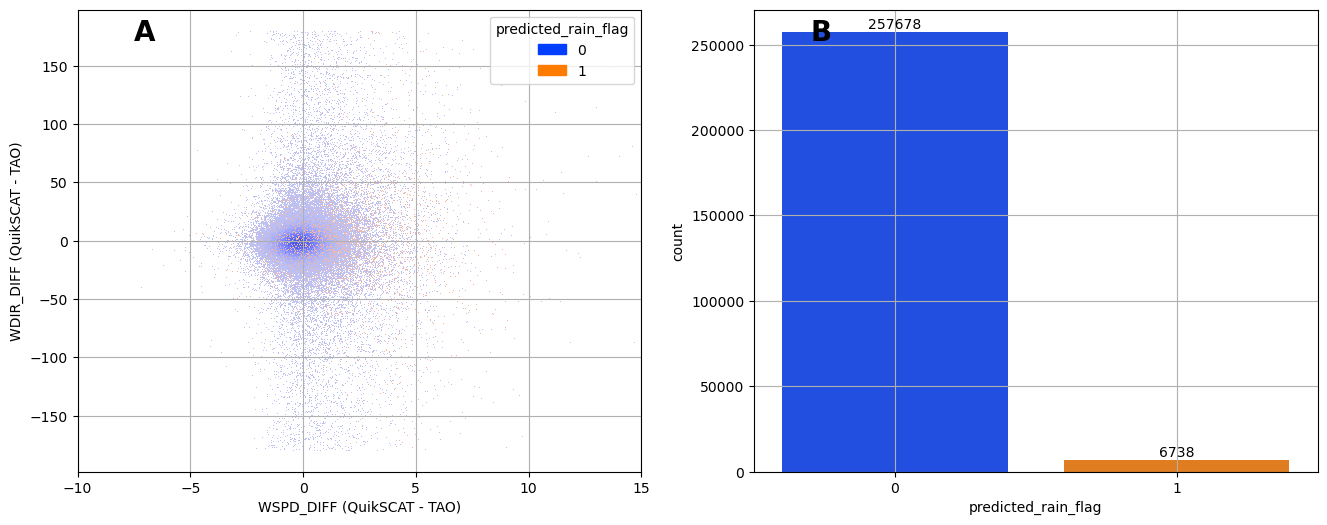

In [10]:

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'WSPD_DIFF (QuikSCAT - TAO)'
ylabel = 'WDIR_DIFF (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='predicted_rain_flag', common_norm=True, #cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='predicted_rain_flag',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
#ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [11]:
subdf = df.loc[df['predicted_rain_flag'] == 1]

In [12]:
list(subdf.keys())

['WDIR (TAO)',
 'WDIR_QC',
 'WDIR_DM',
 'WSPD (TAO)',
 'WSPD_QC',
 'WSPD_DM',
 'UWND (TAO)',
 'VWND (TAO)',
 'SST (TAO)',
 'SST_QC',
 'SST_DM',
 'RELH (TAO)',
 'RELH_QC',
 'RELH_DM',
 'AIRT (TAO)',
 'AIRT_QC',
 'AIRT_DM',
 'WSPD_10N (TAO)',
 'WSPD_10 (TAO)',
 'VHM0',
 'VHM0_SW1',
 'VHM0_SW2',
 'VHM0_WW',
 'VMDR',
 'VMDR_SW1',
 'VMDR_SW2',
 'VMDR_WW',
 'VPED',
 'VSDX',
 'VSDY',
 'VTM01_SW1',
 'VTM01_SW2',
 'VTM01_WW',
 'VTM02',
 'VTM10',
 'VTPK',
 'WAVE_TIME',
 'vo',
 'zos',
 'uo',
 'thetao',
 'so',
 'GLORYS_TIME',
 'mean_WSPD',
 'std_WSPD',
 'mean_WSPD_10N',
 'std_WSPD_10N',
 'mean_UWND_10N',
 'std_UWND_10N',
 'mean_VWND_10N',
 'std_VWND_10N',
 'mean_WDIR',
 'std_WDIR',
 'mean_cosWDIR',
 'std_cosWDIR',
 'mean_sinWDIR',
 'std_sinWDIR',
 'mean_SST',
 'std_SST',
 'mean_AIRT',
 'std_AIRT',
 'mean_SST - AIRT',
 'std_SST - AIRT',
 'mean_RELH',
 'std_RELH',
 'LATITUDE',
 'LONGITUDE',
 'TAO_TIME',
 'Deployment index',
 'num_ambiguities_speed',
 'num_ambiguities_direction',
 'WSPD_10N (QuikSCAT

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

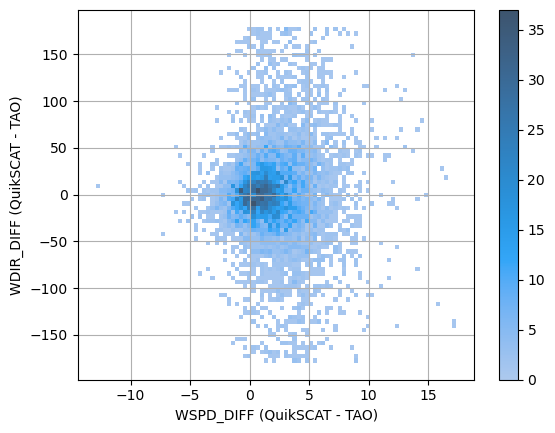

In [13]:
sns.histplot(subdf, x=xlabel, y = ylabel, cbar = True)
plt.grid(True)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-12.92839216, -12.32218772, -11.71598328, -11.10977885,
        -10.50357441,  -9.89736998,  -9.29116554,  -8.6849611 ,
         -8.07875667,  -7.47255223,  -6.86634779,  -6.26014336,
         -5.65393892,  -5.04773449,  -4.44153005,  -3.83532561,
         -3.22912118,  -2.62291674,  -2.01671231,  -1.41050787,
         -0.80430343,  -0.198099  ,   0.40810544,   1.01430987,
          1.62051431,   2.22671875,   2.83292318,   3.43912762,
          4.04533206,   4.65153649,   5.25774093,   5.86394536,
          6.4701498 ,   7.07635424,   7.68255867,   8.28876311,
          8.89496754,   9.50117198,  10.10737642,  10.71358085,
         11.31978529,  11.92598973,  12.53219416,  13.1383986 ,
         13.74460303,  14.35080747,  14.9570119

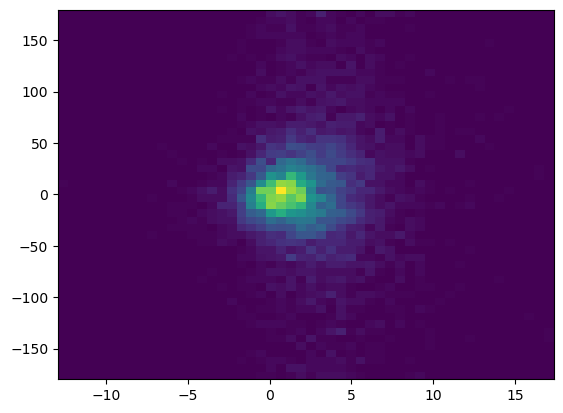

In [14]:
xmax, xmin, ymax, ymin = np.max(subdf[xlabel]), np.min(subdf[xlabel]), np.max(subdf[ylabel]), np.min(subdf[ylabel]) 
plt.hist2d(subdf[xlabel], subdf[ylabel], range = [[xmin, xmax], [ymin, ymax]], bins=(50,50))

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

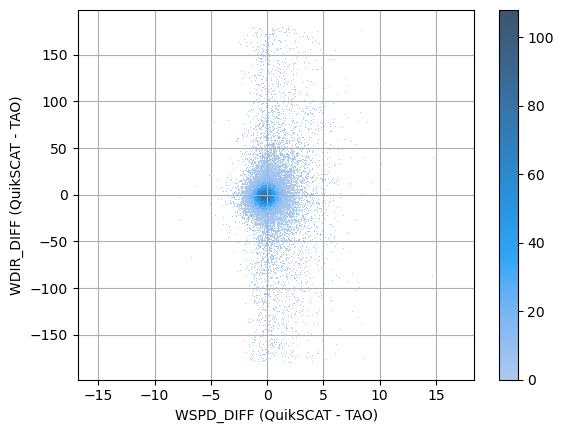

In [15]:
subdf = df.loc[df['predicted_rain_flag'] == 0]
sns.histplot(subdf, x=xlabel, y = ylabel, cbar = True)
plt.grid(True)

In [16]:
def getGoodBad(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:    
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    
    if isPresent:
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Neutral Wind Speed at 10m (TAO)'
        else:
            TAOlabel = f'mean_WSPD_10N'
        QSspeed = subDF['Wind Speed (QuikSCAT)'].to_numpy()
        TAOspeed = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999

def getDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Wind Direction (TAO)'
            TAOdir = subDF[TAOlabel].to_numpy()
        else:
            TAOlabel = f'mean_cosWDIR'
            cos = subDF[TAOlabel].to_numpy()

            TAOlabel = f'mean_sinWDIR'
            sin = subDF[TAOlabel].to_numpy()

            TAOdir = (np.rad2deg(np.arctan2(sin, cos))+360)%360
            # TAOlabel = f'mean WDIR {timeWindow}min'
        #print(TAOdir)
        QSdir = subDF['Wind Direction (QuikSCAT)'].to_numpy()        
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getCosDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'cos(Wind Direction (TAO))'
        else:
            TAOlabel = f'mean_cosWDIR'
        QSdir = subDF['cos(Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getSinDirCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'sin(Wind Direction (TAO))'
        else:
            TAOlabel = f'mean_sinWDIR'
        QSdir = subDF['sin(Wind Direction (QuikSCAT)'].to_numpy()
        TAOdir = subDF[TAOlabel].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

def getXSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        if timeWindow == 10:
            TAOlabel = 'Zonal Wind Speed (TAO)'
        else:
            TAOlabel = f'mean_U10N_x'
        QSspeed_x = subDF['Zonal Wind Speed (QuikSCAT)']
        TAOspeed_x = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        if timeWindow == 10:
            TAOlabel = 'Meridional Wind Speed (TAO)'
        else:
            TAOlabel = f'mean_U10N_y {timeWindow}min'
    if isPresent:
        QSspeed_y = subDF['Meridional Wind Speed (QuikSCAT)']
        TAOspeed_y = subDF[TAOlabel]
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999


def getSpeedStd(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        TAOlabel = f'std_WSPD_10N {timeWindow}min'
        TAOspeedStd = np.nanmean(subDF[TAOlabel].to_numpy())
        return TAOspeedStd
    else:
        return -999

def getcosDirStd(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        TAOlabel = f'std_cosWDIR {timeWindow}min'
        TAO_Std = np.nanmean(subDF[TAOlabel].to_numpy())
        return TAO_Std
    else:
        return -999

def getsinDirStd(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
    if isPresent:
        TAOlabel = f'std_sinWDIR {timeWindow}min'
        TAO_Std = np.nanmean(subDF[TAOlabel].to_numpy())
        return TAO_Std
    else:
        return -999

def getLen(lat, lon, df, timeWindow=10):
    isPresent = False
    lon = (lon + 360)%360
    subDF = df.loc[df['LATITUDE'] == lat]
    subDF = subDF.loc[subDF['LONGITUDE'] == lon]
    if len(subDF) > 0:
        isPresent = True
        return len(subDF)
    else:
        return -999
    

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.1, 0.95, 'B')

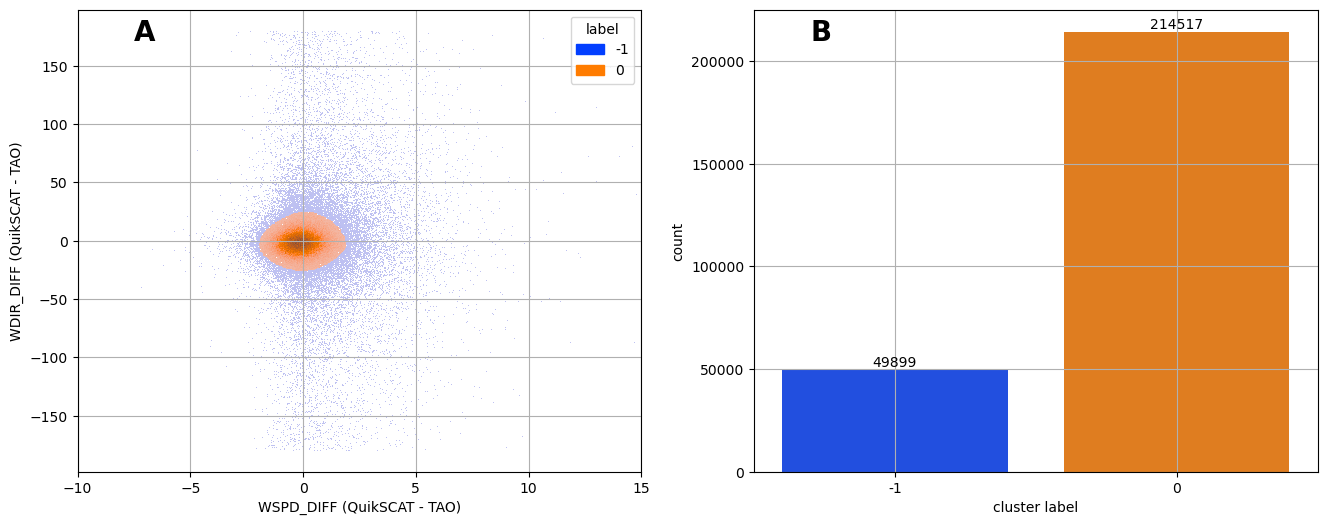

In [17]:
selectX = ['WSPD_DIFF (QuikSCAT - TAO)',
          'cos(WDIR_DIFF (QuikSCAT - TAO))',
          'sin(WDIR_DIFF (QuikSCAT - TAO))']


X = df[selectX]

normX = (X - X.mean(axis=0))/ X.std(axis=0)

# kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# df['label'] = kmeans.labels_

dbscan = DBSCAN(eps=0.15, min_samples= 500)
df['label'] = dbscan.fit_predict(normX)

# optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# df['label'] = optics.fit_predict(normX)

fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'WSPD_DIFF (QuikSCAT - TAO)'
ylabel = 'WDIR_DIFF (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


#plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [18]:
# selectX = ['WSPD_DIFF (QuikSCAT - TAO 2hr mean)',
#           'cos(WDIR_DIFF (QuikSCAT - TAO 2hr mean))',
#           'sin(WDIR_DIFF (QuikSCAT - TAO 2hr mean))']


# X = df[selectX]

# normX = (X - X.mean(axis=0))/ X.std(axis=0)

# # kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
# # df['label'] = kmeans.labels_

# dbscan = DBSCAN(eps=0.15, min_samples= 500)
# df['label'] = dbscan.fit_predict(normX)

# # optics = OPTICS(min_samples=50 ) #cluster_method='dbscan', eps=0.25)
# # df['label'] = optics.fit_predict(normX)

# fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

# ax = axes[0]
# # ax.remove()  # Remove the existing second subplot
# # ax = fig.add_subplot(121, projection='polar')
# xlabel = 'WSPD_DIFF (QuikSCAT - TAO 2hr mean)'
# ylabel = 'WDIR_DIFF (QuikSCAT - TAO 2hr mean)'

# s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
#                 hue='label', common_norm=True,
#                 palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')

# ax.text(0.1, 0.95, 'A', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 20)

# ax.set_xlim(-10,15)

# ax = axes[1]
# s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)
# s.bar_label(s.containers[0])

# ax.grid(visible=True, which='both', axis='both')
# ax.set_xlabel('cluster label')
# #ax.set_ylabel('cluster label')

# ax.text(0.1, 0.95, 'B', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 20)


# #plt.savefig('PDF_byCluster_10min.png', dpi=100)

In [19]:
badAndRain = np.logical_and(df['label'] == -1, df['predicted_rain_flag'] == 1) 
print(np.sum(badAndRain), np.sum(df['label'] == -1), np.sum(badAndRain)/np.sum(df['label'] == -1) * 100)

goodAndRain = np.logical_and(df['label'] == 0, df['predicted_rain_flag'] == 1) 
print(np.sum(goodAndRain), np.sum(df['label'] == 0), np.sum(goodAndRain)/np.sum(df['label'] == 0) * 100)

barData = {'bad and \n rain' : np.sum(badAndRain), 
           'good and \n rain' : np.sum(goodAndRain)}

bar_df = pd.DataFrame.from_dict(barData, orient='index', columns=['count']).reset_index()
bar_df.columns = ['label', 'count']

4965 49899 9.950099200384777
1773 214517 0.8265079224490367


/tmp/ipykernel_728584/2527580152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subDF['Matchup'] = Matchups
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/s

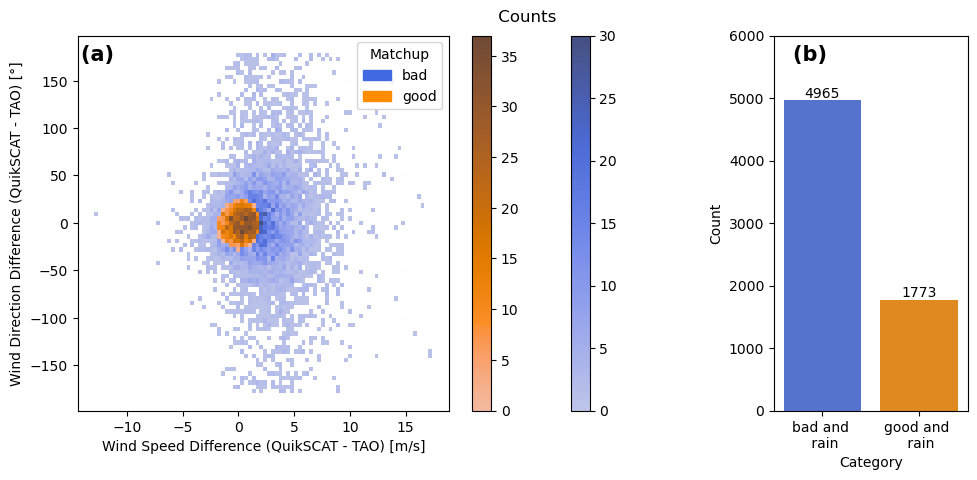

In [22]:
subDF = df.loc[df['predicted_rain_flag'] ==1]

Matchups = ['good' if label == 0 else 'bad' for label in subDF['label'].values]
subDF['Matchup'] = Matchups

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1], left = 0.1, right = 0.99, bottom = 0.15, top = 0.9, wspace=0.3)

# Joint and marginals (LEFT)
ax_hist = fig.add_subplot(gs[0])
ax_count = fig.add_subplot(gs[1])

g = sns.histplot(
    data=subDF, 
    x=xlabel, 
    y=ylabel, 
    hue='Matchup', 
    palette={'good': 'darkorange', 'bad': 'royalblue'}, 
    common_norm=False, 
    cbar=True, 
    ax = ax_hist
)
ax_hist.set_xlabel('Wind Speed Difference (QuikSCAT - TAO) [m/s]')
ax_hist.set_ylabel("Wind Direction Difference (QuikSCAT - TAO) [°]")

# Access the colorbar and set title above
cbar = g.figure.axes[-1]  # Colorbar is usually the last axis
cbar.set_title('     Counts', loc='left', pad=10)  # Title on top
ax_hist.grid(linewidth = 0.01,alpha = 0.25)

ax_hist.text(0.01, 0.95, '(a) ', horizontalalignment='left',
        verticalalignment='center', transform=ax_hist.transAxes,
        weight = 'heavy', fontsize = 15)


s = sns.barplot(data=bar_df, x='label', y='count', palette={'bad and \n rain': 'royalblue', 
                                                            'good and \n rain': 'darkorange'}, 
                ax = ax_count)
for container in s.containers:
    s.bar_label(container)
ax_count.set_ylim((0, 6000))
plt.xlabel('Category')
plt.ylabel('Count')
ax_count.text(0.1, 0.95, '(b) ', horizontalalignment='left',
        verticalalignment='center', transform=ax_count.transAxes,
        weight = 'heavy', fontsize = 15)


plt.savefig('rainflagRandomForest.pdf', dpi=100)

#### 

In [ ]:

plt.title('Bar Plot of Matchup Categories')
#plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
sns.countplot(bar_df, x = 'label')

In [ ]:
subDF = df.copy() #loc[df['predicted_rain_flag'] ==1]
s = sns.countplot(subDF, x = 'label', hue = 'predicted_rain_flag')
s.bar_label(s.containers[0])

In [ ]:
subDF = df.loc[df['label'] ==-1]
#subDF = subDF.loc[subDF['predicted_rain_flag'] == 1]
sns.histplot(subDF, x=xlabel, y = ylabel, hue = 'predicted_rain_flag', common_norm=True, cbar = True)
plt.grid(True)

In [ ]:
subDF = df.loc[df['label'] ==0]
#subDF = subDF.loc[subDF['predicted_rain_flag'] == 1]
sns.histplot(subDF, x=xlabel, y = ylabel, hue = 'predicted_rain_flag', common_norm=True, cbar = True)
plt.grid(True)

In [ ]:
subDF = df.loc[badAndRain]
print(len(subDF))
ssubDF = df.loc[df['label'] ==-1]
print(len(subDF)/len(ssubDF) * 100)
sns.histplot(subDF, x=xlabel, y = ylabel, cbar = True, bins = 100)
plt.grid(True)

In [ ]:
rainLabelInBoth = 

In [ ]:
subDF = df.loc[goodAndRain]
sns.histplot(subDF, x=xlabel, y = ylabel, cbar = True, bins = 50)
plt.grid(True)

In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])
        

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

badAndNoRain = np.logical_and(df['label'] == -1, df['predicted_rain_flag'] == 0) 
subDF = df.loc[badAndNoRain]
#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd =  getSpeedCorrelation(lat, lon, subDF, timeWindow = '2hr')
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0.75, vmax= 0.9,s = 60, cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('wind speed correlation')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)



In [ ]:
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

badAndNoRain = np.logical_and(df['label'] == -1, df['predicted_rain_flag'] == 0) 
subDF = df.loc[badAndNoRain]
#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd =  getCosDirCorrelation(lat, lon, subDF, timeWindow='2hr')
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd,vmin=0.33, vmax= 0.7, s = 60, cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('cos wind direction correlatoin')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)




In [ ]:
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

badAndNoRain = np.logical_and(df['label'] == -1, df['predicted_rain_flag'] == 0) 
subDF = df.loc[badAndNoRain]
#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd =  getSinDirCorrelation(lat, lon, subDF, timeWindow='2hr')
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd,vmin=0.33, vmax= 0.7, s = 60, cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('sin wind direction correlatoin')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)




In [ ]:
list(df.keys())

In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])
        

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

badAndNoRain = np.logical_and(df['label'] == -1, df['predicted_rain_flag'] == 0) 
badAll = df['label'] == -1
subDF = df.loc[badAndNoRain]
subDF2 = df.loc[badAll]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd =  getLen(lat, lon, subDF, timeWindow = '2hr')
    wspdStd2 = getLen(lat, lon, subDF2, timeWindow = '2hr')
    #print(wspdStd, wspdStd2)
    r =  wspdStd/wspdStd2
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{r*100:6.2f}%')
        x = ax.scatter(xpos, lat, c=r*100, s = 60, vmin = 85, vmax=100, cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad and No Rain Data Points \n with respect to Bad Data points')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)



In [ ]:

fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

badAndNoRain = np.logical_and(df['label'] == 0, df['predicted_rain_flag'] == 1) 
badAll = df['label'] == -1
subDF = df.loc[badAndNoRain]
subDF2 = df.loc[badAll]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd =  getLen(lat, lon, subDF, timeWindow = '2hr')
    wspdStd2 = getLen(lat, lon, subDF2, timeWindow = '2hr')
    #print(wspdStd, wspdStd2)
    r =  wspdStd/wspdStd2
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{r*100:6.2f}%')
        x = ax.scatter(xpos, lat, c=r*100, s = 60, vmin = 0, vmax=3, cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad and With Rain Data Points \n with respect to Bad Data points')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)



In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])
        

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

badAndNoRain = np.logical_and(df['label'] == -1, df['predicted_rain_flag'] == 1) 
badAll = df['label'] == -1
subDF = df.loc[badAndNoRain]
subDF2 = df.copy()
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd =  getLen(lat, lon, subDF, timeWindow = '2hr')
    wspdStd2 = getLen(lat, lon, subDF2, timeWindow = '2hr')
    #print(wspdStd, wspdStd2)
    r =  wspdStd/wspdStd2
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{r*100:6.2f}%')
        x = ax.scatter(xpos, lat, c=r*100, s = 60, vmin = 0, vmax=5, cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad and with Rain Data Points \n with respect to all Data points')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)



In [ ]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])
        

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

badAndNoRain = np.logical_and(df['label'] == -1, df['predicted_rain_flag'] == 0) 
badAll = df['label'] == -1
subDF = df.loc[badAndNoRain]
subDF2 = df.copy()
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd =  getLen(lat, lon, subDF, timeWindow = '2hr')
    wspdStd2 = getLen(lat, lon, subDF2, timeWindow = '2hr')
    #print(wspdStd, wspdStd2)
    r =  wspdStd/wspdStd2
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{r*100:6.2f}%')
        x = ax.scatter(xpos, lat, c=r*100, s = 60, vmin = 0, vmax=30, cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad and with No Rain Data Points \n with respect to all Data points')
#ax.scatter(df['LONGITUDE'], df['LATITUDE'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)

